In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
! pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

# **Import Thư Viện**

In [ ]:
import pandas as pd
import random
import shutil
import os
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import base64
import requests
import json

from dotenv import load_dotenv
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from umap import UMAP
from hdbscan import HDBSCAN
from copy import deepcopy
from bertopic.representation import KeyBERTInspired
from sklearn.metrics.pairwise import cosine_similarity

# **Pair label**

In [ ]:
# Giả sử df_sample_2 đã có sẵn từ đoạn code trước
df_sample = pd.read_excel("chuan_other_vai_moi (1).xlsx")

# Gom nhóm sản phẩm theo label
grouped = df_sample.groupby("Predicted Label")["Product List"].apply(list).to_dict()
labels = list(grouped.keys())

# In ra các label có số sản phẩm < 2 để debug
for label, items in grouped.items():
    if len(items) < 2:
        print(f"Label '{label}' có ít hơn 2 sản phẩm ({len(items)}). Không tạo được cặp positive.")

# Tạo positive pairs
positive_pairs = []
n_pos_samples_per_group = 7000

for group, items in grouped.items():
    if len(items) < 2:
        continue
    for _ in range(n_pos_samples_per_group):
        i, j = random.sample(items, 2)
        positive_pairs.append((i, j, group, group, 1))

# Tạo negative pairs
negative_pairs = []
n_neg_samples = len(positive_pairs)

if len(labels) >= 2:
    while len(negative_pairs) < n_neg_samples:
        label_i, label_j = random.sample(labels, 2)
        if label_i == label_j or len(grouped[label_i]) == 0 or len(grouped[label_j]) == 0:
            continue
        p1 = random.choice(grouped[label_i])
        p2 = random.choice(grouped[label_j])
        negative_pairs.append((p1, p2, label_i, label_j, 0))
else:
    print("Không đủ nhóm label khác nhau để tạo cặp negative.")

# Combine và tạo DataFrame
all_pairs = positive_pairs + negative_pairs
random.shuffle(all_pairs)

pair_df = pd.DataFrame(all_pairs, columns=["sentence1", "sentence2", "label1", "label2", "match"])

# Xem thử vài dòng
print(pair_df.head())

# Lưu lại
pair_df.to_excel("pairs_50_vai_50_other.xlsx", index=False)
print("Đã lưu cặp positive/negative vào 'pairs_50_vai_50_other.xlsx'")


                                           sentence1  \
0  sewing thread 50/2 l0400t50/2 t50/2 used in zi...   
1  Vải denim chất liệu 62% Cotton 36% Polyester 2...   
2  polypropylene yarn 150/48 polypropylene multi ...   
3  Woven fabric composed of 53% polyester filamen...   
4  xơ staple tổng hợp từ polyeste tái tạo chưa ch...   

                                           sentence2 label1 label2  match  
0  áo phòng sạch kẻ caro, màu xanh lá, chất liệu ...  Other  Other      1  
1  vải dệt thoi bằng sợi filament tổng hợp ivi230...    Vải    Vải      1  
2  sewing thread from synthetic filament yarn, pa...  Other  Other      1  
3  duc, non woven fabric, 100% polyester, 57g/m2,...    Vải    Vải      1  
4  adhesive coated non woven product non woven in...  Other  Other      1  
Đã lưu cặp positive/negative vào 'pairs_50_vai_50_other.xlsx'


# **embedding_created_train**

In [ ]:
# Load dữ liệu cặp sentence và nhãn
df=pd.read_excel('pairs_50_vai_50_other.xlsx')

df["sentence1"] = df["sentence1"].fillna("").astype(str)
df["sentence2"] = df["sentence2"].fillna("").astype(str)
df["match"] = df["match"].astype(float)

# Chuyển thành list các InputExample
train_examples = [
    InputExample(texts=[row["sentence1"], row["sentence2"]], label=row["match"])
    for _, row in df.iterrows()
]

# Tạo DataLoader để train
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=64)

# Load model
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# Define loss
train_loss = losses.CosineSimilarityLoss(model=model)

# Optional evaluator (if you want)
# evaluator = evaluation.EmbeddingSimilarityEvaluator(sentences1, sentences2, scores)

# Train model
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=1,
    warmup_steps=100,
    output_path="./model_pretrain_new"
)


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


In [ ]:
# Nén toàn bộ thư mục model thành file ZIP
shutil.make_archive("fine_tuned_model_new", 'zip', "./model_pretrain_new")


'/content/fine_tuned_model_new.zip'

In [ ]:
# tải lại model output
from google.colab import drive
drive.mount('/content/drive')

import zipfile

zip_path = "/content/drive/MyDrive/fine_tuned_model_new.zip"
extract_path = "/content/fine_tuned_model_new"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('./fine_tuned_model_new')


Mounted at /content/drive


In [ ]:
df_sample

,Product List,Label new,Predicted Label
0,"ha/03 vải lướivải dệt đã nhuộm 44"" epm poly pa...",Vải,Vải
1,"Synthetic filament woven fabric, density>85% N...",Vải,Vải
2,"100% polyester knitted fabric k.58/60"" size 15...",Vải,Vải
3,"vải 100% cotton fabric 2yds, k. 56""",Vải,Vải
4,"Vải mộc chưa nhuộm, chưa tẩy trắng loại dệt th...",Vải,Vải
...,...,...,...
923,"brand name fabric label, from woven fabric, in...",Phụ_trợ,Other
924,"constructed from impregnated fabric, coated wi...",Phụ_Trợ,Other
925,secondary label fabric label l80g nf0a88v3 cn,Phụ_Trợ,Other
926,all kinds of fabric labels. new 100%. rl/95091...,Phụ_trợ,Other


# **Mean vector of embeddings created for "Other"**

In [ ]:
# Load model
model = model

# Đảm bảo cột Product không bị NaN
# df_sample_2['Product'] = df_sample_2['Product'].fillna('')

# Lọc các dòng có Label = "Other"

# Vector hóa văn bản
embeddings_sample = model.encode(
    df_sample[df_sample['Predicted Label']=='Other']['Product List'].astype(str).tolist(),
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
# Tính vector trung bình từ embeddings (50, D)
mean_vector = np.mean(embeddings_sample, axis=0)

# In kích thước và giá trị vector trung bình
print("Vector trung bình có shape:", mean_vector.shape)
print(mean_vector)


Vector trung bình có shape: (384,)
[-0.1387087   0.6573332  -0.03273694 -0.2300522   0.15772179  0.0213685
  0.35555035 -0.02150064  0.3076507  -0.37926129  0.32905     0.01560192
 -0.12726729 -0.02030266  0.09837085  0.35107622  0.4848103   0.50777245
  0.4318435  -0.33504462  0.22105727 -0.11031792 -0.17954905  0.094218
 -0.49205452  0.3593189   0.17098042  0.21485992 -0.10424613 -0.04016317
 -0.12218285  0.13855559  0.20040509  0.19130605  0.18938507 -0.38460058
 -0.11312667 -0.28165427 -0.30000895 -0.11847676 -0.20567116 -0.24965343
  0.16141249  0.06783348  0.4515145   0.45410323  0.19514345  0.14932224
  0.44183838 -0.32963443  0.06842633  0.12455612 -0.29221138 -0.36893404
 -0.01233674  0.07911588 -0.14249894  0.21200584  0.10799579 -0.10156811
  0.22884017 -0.37684026 -0.19716515  0.02698448 -0.7061589   0.05514492
 -0.08469203 -0.39435878 -0.0867679  -0.04134425 -0.3236113  -0.25734922
  0.14660928  0.15594597  0.28649542  0.14676276 -0.04080388 -0.23786251
 -0.1169033   0.443

In [ ]:
np.save("mean_vector.npy", mean_vector)
# Load lại: mean_vector = np.load("mean_vector.npy")

In [ ]:
mean_vector = np.load("mean_vector.npy")

# **embeddings created for "Full Data"**

In [ ]:
df = pd.read_excel("random_1000_dong_clean.xlsx")

# Lọc nhãn hợp lệ
df = df[df["Predicted Label"].isin(["Vải", "Other"])].copy()
df["Product List"] = df["Product List"].fillna("").astype(str)

# Encode nhãn
le = LabelEncoder()
labels = df["Predicted Label"].tolist()
y = le.fit_transform(labels)

# Vector hóa văn bản
model_emb = model
X = model_emb.encode(df["Product List"].tolist(), show_progress_bar=True, convert_to_numpy=True)

# Lấy chỉ số tương ứng với nhãn "Phụ_trợ"
label_index_phu_tro = le.transform(["Vải"])[0]

# Lọc embedding + product của các dòng "Phụ_trợ"
mask_phu_tro = (y == label_index_phu_tro)
products_phu_tro = df["Product List"].values[mask_phu_tro]
embeddings_phu_tro = X[mask_phu_tro]

# Gộp thành DataFrame
df_phu_tro = pd.DataFrame({
    "Product List": products_phu_tro,
    "Embedding": [vec.tolist() for vec in embeddings_phu_tro],
    "Predicted Label": df["Predicted Label"].values[mask_phu_tro]
})


Batches:   0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
df_phu_tro

,Product List,Embedding,Predicted Label
0,"100% polyester yarn knitted fabric, dyed, unim...","[0.44052398204803467, -0.20963016152381897, 0....",Vải
1,100% polyester yarn dyed soft satin 7068 (100%...,"[-0.24547532200813293, 0.4747648537158966, -0....",Vải
2,"filament yarn woven fabric, dyed im564242 97% ...","[0.45214492082595825, -0.21026338636875153, 0....",Vải
3,"filament woven fabric, containing less than 85...","[0.46389439702033997, -0.19566231966018677, 0....",Vải
4,wool yarn (multiple yarn1 12nm 60% recycle pol...,"[-0.23294630646705627, 0.6264267563819885, -0....",Vải
...,...,...,...
527,42 100% polyester synthetic staple fiber woven...,"[0.48910096287727356, -0.21558831632137299, 0....",Vải
528,"dyeed, cut, synthetic fiber knit fabric, 60% c...","[0.4434514343738556, -0.20662929117679596, 0.7...",Vải
529,"dyeed synthetic fiber knit fabric, composition...","[0.4617866277694702, -0.2119113653898239, 0.69...",Vải
530,synthetic staple fiber woven fabric yrd 10l 32...,"[0.48628243803977966, -0.1814851015806198, 0.7...",Vải


# **clusters topics**

In [ ]:
# Giảm số chiều của embedding từ 384 xuống 7 chiều
umap_model = UMAP(
n_components=7, min_dist=0.0, metric='cosine', random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings_phu_tro)

In [ ]:
# Huấn luyện HDBSCAN và lấy nhãn các cụm
hdbscan_model = HDBSCAN(
min_cluster_size=6, metric="euclidean", cluster_selection_method="eom"
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_

# Số lượng cụm được tạo
len(set(clusters))

21

In [ ]:
reduced_embeddings = UMAP(
n_components=2, min_dist=0.0, metric="cosine", random_state=42
).fit_transform(embeddings_phu_tro)

In [ ]:
texts = df_phu_tro["Product List"].tolist()

# Huấn luyện BERTopic
from bertopic import BERTopic

topic_model = BERTopic(
    embedding_model=model_emb,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
)
topics, probs = topic_model.fit_transform(texts, embeddings_phu_tro)


2025-08-14 08:13:57,835 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-14 08:13:59,283 - BERTopic - Dimensionality - Completed ✓
2025-08-14 08:13:59,285 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-14 08:13:59,300 - BERTopic - Cluster - Completed ✓
2025-08-14 08:13:59,304 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-14 08:13:59,337 - BERTopic - Representation - Completed ✓


In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,33,-1_to_knitted_synthetic_yrd,"[to, knitted, synthetic, yrd, shoe, attach, in...",[100% polyester dyed synthetic fiber knitted f...
1,0,92,0_yarn_for_rubber_from,"[yarn, for, rubber, from, 100, used, new, made...",[rubber yarn wrapped with polyester knitted fa...
2,1,88,1_woven_100_m2_size,"[woven, 100, m2, size, fabric, staple, new, po...",[29 synthetic staple fiber woven fabric 65% po...
3,2,38,2_dyeed_knit_100_synthetic,"[dyeed, knit, 100, synthetic, polyester, new, ...",[dyeed 100% polyester synthetic fiber knit fab...
4,3,31,3_woven_staple_size_100,"[woven, staple, size, 100, bags, shrink, impre...","[v21 synthetic staple fiber woven fabric, twil..."
5,4,30,4_kg_brand_weight_dyed,"[kg, brand, weight, dyed, m2, 100, staple, 54,...","[1 synthetic staple fiber woven fabric (dyed, ..."
6,5,22,5_twill_in_163_205g,"[twill, in, 163, 205g, cm, sewing, 61023, 55, ...","[v99 polyester staple fiber woven fabric, twil..."
7,6,22,6_lining_ryp_matte_yrd,"[lining, ryp, matte, yrd, 44, rec, pm, knit, p...",[synthetic staple fiber woven fabric yrd 6dl (...
8,7,21,7_cut_kt_composition_dyeed,"[cut, kt, composition, dyeed, front, embroider...","[dyeed, cut, synthetic fiber knit fabric, 100%..."
9,8,21,8_a10651k_vamp_winflo_zonal,"[a10651k, vamp, winflo, zonal, spacer, su23, s...","[polyester staple fiber woven fabric su23,winf..."


In [ ]:
original_topics = deepcopy(topic_model.topic_representations_)
def topic_differences(model, original_topics, nr_topics=len(set(clusters))-1):
  """Show the differences in topic representations between two models """
  df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
  for topic in range(nr_topics):
    # Lấy 5 từ hàng đầu của mỗi chủ đề từ mô hình gốc và mô hình mới
    og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
    new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
    df.loc[len(df)] = [topic, og_words, new_words]
  return df

In [ ]:
# Cập nhật đại diện chủ đề bằng KeyBERTInspired
representation_model = KeyBERTInspired()
topic_model.update_topics(df_phu_tro["Product List"].tolist(), representation_model=representation_model)
# Hiển thị sự khác biệt giữa chủ đề gốc và chủ đề cập nhật
topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,yarn | for | rubber | from | 100,compressport | rubber | manufacturer | filamen...
1,1,woven | 100 | m2 | size | fabric,fabric | woven | fiber | weave | cotton
2,2,dyeed | knit | 100 | synthetic | polyester,fabric | knitted | knit | fiber | cotton
3,3,woven | staple | size | 100 | bags,fabric | woven | wool | fiber | cotton
4,4,kg | brand | weight | dyed | m2,fabric | woven | knitted | fiber | cotton
5,5,twill | in | 163 | 205g | cm,fabric | woven | fiber | cotton | dyed
6,6,lining | ryp | matte | yrd | 44,fabric | woven | knit | fiber | polyester
7,7,cut | kt | composition | dyeed | front,fabric | knitted | knit | fiber | cotton
8,8,a10651k | vamp | winflo | zonal | spacer,fabric | woven | fiber | cotton | polyester
9,9,1nl | kg | brand | weight | 100,fabric | woven | fiber | dyed | polyester


In [ ]:


# Load file .env
load_dotenv("my_key.env")

# Tạo danh sách thông tin các chủ đề
topic_infos = []

# Lấy từ khóa của tất cả topics
all_topics = topic_model.get_topics()
# Lấy các văn bản đại diện cho mỗi topics
rep_docs = topic_model.get_representative_docs()

for topic_id in all_topics:
    if topic_id == -1:
        continue  # bỏ outliers

    keywords = [word for word, _ in all_topics[topic_id][:5]]
    documents = rep_docs.get(topic_id, [])[:5]

    topic_infos.append({
        "topic_id": topic_id,
        "keywords": keywords,
        "documents": documents
    })


# Hàm tạo prompt
def build_prompt(keywords, documents):
    # Cắt ngắn văn bản để tránh input quá dài
    truncated_docs = [doc[:200].replace('\n', ' ') for doc in documents[:5]]
    return f"""
You are a helpful AI assistant.

I have a topic that contains the following documents:
{chr(10).join(truncated_docs)}

The topic is described by the following keywords: {", ".join(keywords)}.

Based on the information above, extract a short topic label in the following format:

topic: <short topic label>
""".strip()


# Lấy nhãn chủ đề qua OpenRouter API
def get_topic_label(prompt, model="qwen/qwen-2.5-7b-instruct"):
    api_key = os.getenv("OPENROUTER_API_KEY", "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")  # Use env variable or replace manually

    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json",
    }

    body = {
        "model": model,
        "messages": [
            {"role": "system", "content": "You are a concise label generator."},
            {"role": "user", "content": prompt}
        ],
        "temperature": 0.3,
        "max_tokens": 20,
    }

    try:
        response = requests.post("https://openrouter.ai/api/v1/chat/completions", json=body, headers=headers)
        response.raise_for_status()
        result = response.json()["choices"][0]["message"]["content"].strip()
        return result
    except Exception as e:
        print(f"[Error] Topic label generation failed: {e}")
        return "topic: Unknown"


# Tạo nhãn cho các chủ đề
labels = {}
for info in topic_infos:
    prompt = build_prompt(info["keywords"], info["documents"])
    label = get_topic_label(prompt)
    print(f"Generated label for Topic {info['topic_id']}: {label}")
    labels[info["topic_id"]] = label

# Lưu kết quả ra file JSON
with open("topic_labels.json", "w", encoding="utf-8") as f:
    json.dump(labels, f, ensure_ascii=False, indent=2)

Generated label for Topic 0: topic: Rubber Yarn and Fabric Products
Generated label for Topic 1: topic: Woven Fabric with Cotton
Generated label for Topic 2: topic: Polyester Knit Fabric
Generated label for Topic 3: topic: Synthetic Woven Fabric
Generated label for Topic 4: topic: Polyester Woven Fabric Samples
Generated label for Topic 5: topic: Polyester Woven Fabric
Generated label for Topic 6: topic: Synthetic Woven Knit Fabric
Generated label for Topic 7: topic: Polyester Knit Fabric Pieces
Generated label for Topic 8: topic: Polyester Woven Fabric
Generated label for Topic 9: topic: Polyester Woven Fabric
Generated label for Topic 10: topic: Synthetic Staple Fiber Woven Fabric
Generated label for Topic 11: topic: Knit Fabric and Fiber Mix
Generated label for Topic 12: topic: Synthetic Knitted Fabrics
Generated label for Topic 13: topic: Knitted Fabrics with Elastomeric Yarn
Generated label for Topic 14: topic: Polyester Woven Fabric
Generated label for Topic 15: topic: Synthetic 

In [ ]:
# Visualize topics and documents
fig = topic_model.visualize_documents(
    df_phu_tro['Product List'],
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)

fig.update_layout(font=dict(size=16))

In [ ]:
topic_model.get_document_info(df_phu_tro['Product List'] )

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,"100% polyester yarn knitted fabric, dyed, unim...",-1,-1_fabric_woven_knitted_fiber,"[fabric, woven, knitted, fiber, dyed, polyeste...",[100% polyester dyed synthetic fiber knitted f...,fabric - woven - knitted - fiber - dyed - poly...,0.000000,False
1,100% polyester yarn dyed soft satin 7068 (100%...,0,0_compressport_rubber_manufacturer_filament,"[compressport, rubber, manufacturer, filament,...",[rubber yarn wrapped with polyester knitted fa...,compressport - rubber - manufacturer - filamen...,1.000000,False
2,"filament yarn woven fabric, dyed im564242 97% ...",1,1_fabric_woven_fiber_weave,"[fabric, woven, fiber, weave, cotton, dyed, po...",[29 synthetic staple fiber woven fabric 65% po...,fabric - woven - fiber - weave - cotton - dyed...,1.000000,False
3,"filament woven fabric, containing less than 85...",1,1_fabric_woven_fiber_weave,"[fabric, woven, fiber, weave, cotton, dyed, po...",[29 synthetic staple fiber woven fabric 65% po...,fabric - woven - fiber - weave - cotton - dyed...,1.000000,False
4,wool yarn (multiple yarn1 12nm 60% recycle pol...,0,0_compressport_rubber_manufacturer_filament,"[compressport, rubber, manufacturer, filament,...",[rubber yarn wrapped with polyester knitted fa...,compressport - rubber - manufacturer - filamen...,1.000000,False
...,...,...,...,...,...,...,...,...
527,42 100% polyester synthetic staple fiber woven...,1,1_fabric_woven_fiber_weave,"[fabric, woven, fiber, weave, cotton, dyed, po...",[29 synthetic staple fiber woven fabric 65% po...,fabric - woven - fiber - weave - cotton - dyed...,1.000000,False
528,"dyeed, cut, synthetic fiber knit fabric, 60% c...",7,7_fabric_knitted_knit_fiber,"[fabric, knitted, knit, fiber, cotton, dyed, p...","[dyeed, cut, synthetic fiber knit fabric, 100%...",fabric - knitted - knit - fiber - cotton - dye...,0.889575,False
529,"dyeed synthetic fiber knit fabric, composition...",2,2_fabric_knitted_knit_fiber,"[fabric, knitted, knit, fiber, cotton, dyed, p...",[dyeed 100% polyester synthetic fiber knit fab...,fabric - knitted - knit - fiber - cotton - dye...,0.714821,False
530,synthetic staple fiber woven fabric yrd 10l 32...,10,10_fabric_woven_textile_knit,"[fabric, woven, textile, knit, fiber, poly, ny...",[synthetic staple fiber woven fabric yrd 39y d...,fabric - woven - textile - knit - fiber - poly...,1.000000,False


In [ ]:
# Đổi tên cột 'Product' để join với docs_info
df_phu_tro_renamed = df_phu_tro.rename(columns={"Product List": "Document"})

# Lọc các dòng thuộc topic 0, 1, 2
docs_selected = topic_model.get_document_info(df_phu_tro['Product List'])
docs_selected = docs_selected[docs_selected['Topic'].isin(range(len(set(clusters))-1))][['Document', 'Topic']]

# Gộp với embedding theo Document
merged_df = docs_selected.merge(df_phu_tro_renamed[['Document', 'Embedding']], on='Document', how='left')

print(merged_df.head())

                                            Document  Topic  \
0  100% polyester yarn dyed soft satin 7068 (100%...      0   
1  filament yarn woven fabric, dyed im564242 97% ...      1   
2  filament woven fabric, containing less than 85...      1   
3  wool yarn (multiple yarn1 12nm 60% recycle pol...      0   
4  elastic yarn knitted fabric, weight 887.71g m2...     18   

                                           Embedding  
0  [-0.24547532200813293, 0.4747648537158966, -0....  
1  [0.45214492082595825, -0.21026338636875153, 0....  
2  [0.46389439702033997, -0.19566231966018677, 0....  
3  [-0.23294630646705627, 0.6264267563819885, -0....  
4  [0.440572589635849, -0.21136341989040375, 0.70...  


# **cosine_similarity**

In [ ]:
# Chuyển danh sách embedding thành numpy array (n_samples, D)
embeddings_array = np.vstack(merged_df['Embedding'].values)

# # Dùng vector trung bình đã tính sẵn: mean_vector_2
# mean_vector_reshaped = mean_vector_2.reshape(1, -1)
mean_vector_reshaped = np.array(mean_vector).reshape(1, -1)  # (1, D)

# Tính cosine similarity giữa từng vector với mean_vector_2
similarities = cosine_similarity(embeddings_array, mean_vector_reshaped).flatten()

# Similarity vào DataFrame
merged_df["Similarity_to_Mean"] = similarities

print(merged_df[["Document", "Topic", "Similarity_to_Mean"]].head())


                                            Document  Topic  \
0  100% polyester yarn dyed soft satin 7068 (100%...      0   
1  filament yarn woven fabric, dyed im564242 97% ...      1   
2  filament woven fabric, containing less than 85...      1   
3  wool yarn (multiple yarn1 12nm 60% recycle pol...      0   
4  elastic yarn knitted fabric, weight 887.71g m2...     18   

   Similarity_to_Mean  
0            0.942212  
1           -0.001179  
2            0.005776  
3            0.981760  
4           -0.014205  


In [ ]:
merged_df

,Document,Topic,Embedding,Similarity_to_Mean
0,100% polyester yarn dyed soft satin 7068 (100%...,0,"[-0.24547532200813293, 0.4747648537158966, -0....",0.942212
1,"filament yarn woven fabric, dyed im564242 97% ...",1,"[0.45214492082595825, -0.21026338636875153, 0....",-0.001179
2,"filament woven fabric, containing less than 85...",1,"[0.46389439702033997, -0.19566231966018677, 0....",0.005776
3,wool yarn (multiple yarn1 12nm 60% recycle pol...,0,"[-0.23294630646705627, 0.6264267563819885, -0....",0.981760
4,"elastic yarn knitted fabric, weight 887.71g m2...",18,"[0.440572589635849, -0.21136341989040375, 0.70...",-0.014205
...,...,...,...,...
494,42 100% polyester synthetic staple fiber woven...,1,"[0.48910096287727356, -0.21558831632137299, 0....",-0.006456
495,"dyeed, cut, synthetic fiber knit fabric, 60% c...",7,"[0.4434514343738556, -0.20662929117679596, 0.7...",-0.007469
496,"dyeed synthetic fiber knit fabric, composition...",2,"[0.4617866277694702, -0.2119113653898239, 0.69...",-0.011368
497,synthetic staple fiber woven fabric yrd 10l 32...,10,"[0.48628243803977966, -0.1814851015806198, 0.7...",0.001979


/tmp/ipython-input-4068835160.py:16: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



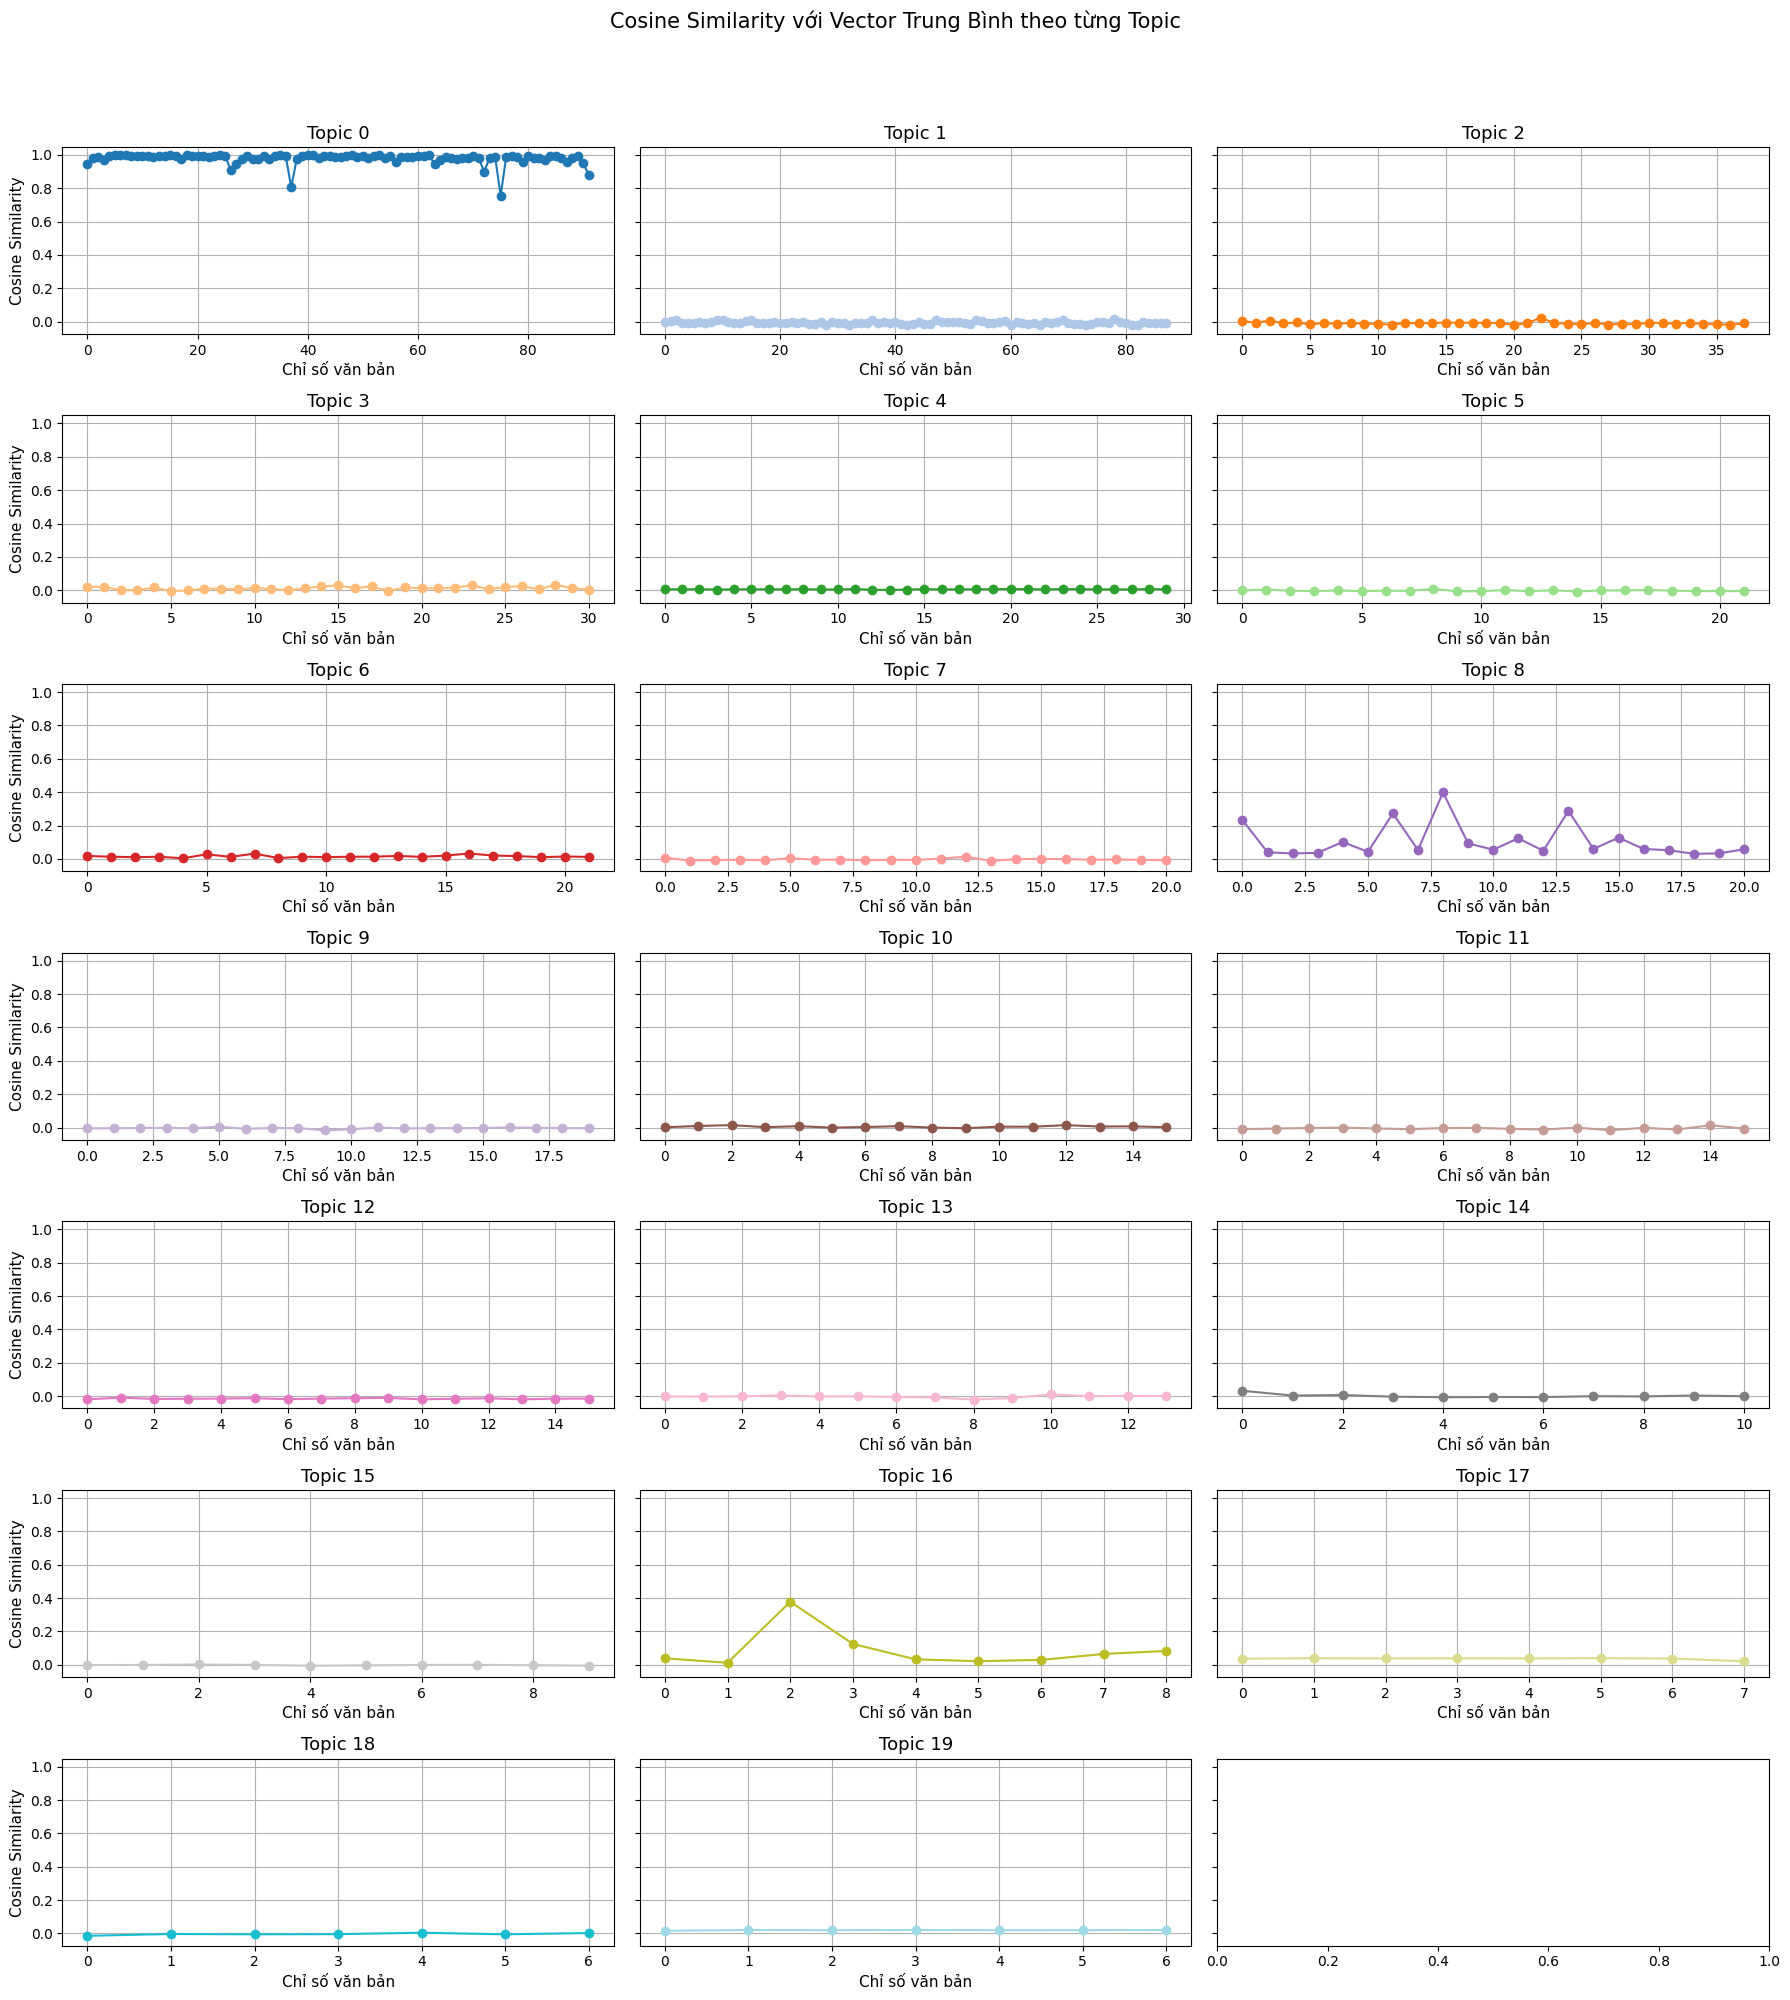

In [ ]:
num_topics = len(set(clusters)) - 1

# Tính toán số hàng và cột phù hợp để hiển thị subplot
ncols = 3
nrows = (num_topics + ncols - 1) // ncols  # Làm tròn lên

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 3 * nrows), sharey=True)

# Tạo bảng màu tự động dựa trên số lượng topic
color_map = cm.get_cmap('tab20', num_topics)
colors = {i: color_map(i) for i in range(num_topics)}

for i, topic_id in enumerate(range(len(set(clusters)) - 1)):
    topic_data = merged_df[merged_df["Topic"] == topic_id].copy()
    topic_data["Index"] = range(len(topic_data))

    ax = axes.flat[i]
    ax.plot(
        topic_data["Index"],
        topic_data["Similarity_to_Mean"],
        marker='o',
        linestyle='-',
        color=colors[topic_id]
    )
    ax.set_title(f"Topic {topic_id}", fontsize=13)
    ax.set_xlabel("Chỉ số văn bản", fontsize=11)
    if i % 3 == 0:  # Cột đầu tiên
        ax.set_ylabel("Cosine Similarity", fontsize=11)
    ax.grid(True)

plt.suptitle("Cosine Similarity với Vector Trung Bình theo từng Topic", fontsize=15)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
merged_df

,Document,Topic,Embedding,Similarity_to_Mean
0,100% polyester yarn dyed soft satin 7068 (100%...,0,"[-0.24547532200813293, 0.4747648537158966, -0....",0.942212
1,"filament yarn woven fabric, dyed im564242 97% ...",1,"[0.45214492082595825, -0.21026338636875153, 0....",-0.001179
2,"filament woven fabric, containing less than 85...",1,"[0.46389439702033997, -0.19566231966018677, 0....",0.005776
3,wool yarn (multiple yarn1 12nm 60% recycle pol...,0,"[-0.23294630646705627, 0.6264267563819885, -0....",0.981760
4,"elastic yarn knitted fabric, weight 887.71g m2...",18,"[0.440572589635849, -0.21136341989040375, 0.70...",-0.014205
...,...,...,...,...
494,42 100% polyester synthetic staple fiber woven...,1,"[0.48910096287727356, -0.21558831632137299, 0....",-0.006456
495,"dyeed, cut, synthetic fiber knit fabric, 60% c...",7,"[0.4434514343738556, -0.20662929117679596, 0.7...",-0.007469
496,"dyeed synthetic fiber knit fabric, composition...",2,"[0.4617866277694702, -0.2119113653898239, 0.69...",-0.011368
497,synthetic staple fiber woven fabric yrd 10l 32...,10,"[0.48628243803977966, -0.1814851015806198, 0.7...",0.001979


In [ ]:
# Tính trung bình Similarity_to_Mean theo từng Topic
topic_mean_sim = merged_df.groupby("Topic")["Similarity_to_Mean"].mean()

# Lọc ra các Topic có trung bình similarity > 0.55
topics_above_threshold = topic_mean_sim[topic_mean_sim >= 0.55].index.tolist()

# Giữ lại các dòng thuộc các Topic có trung bình similarity > 0.55
filtered_df = merged_df[merged_df["Topic"].isin(topics_above_threshold)]

print(filtered_df[["Topic", "Document", "Similarity_to_Mean"]])


     Topic                                           Document  \
0        0  100% polyester yarn dyed soft satin 7068 (100%...   
3        0  wool yarn (multiple yarn1 12nm 60% recycle pol...   
6        0  wool yarn (55% wool 30% polyester 10% nylon 5%...   
7        0  wool yarn of all kinds (2070 92% nylon 8% span...   
8        0  synthetic filament yarn (black) from polyester...   
..     ...                                                ...   
438      0  synthetic monofilament fiber (black) from poly...   
462      0  matt span (pu coating) (w4) man made fiber fab...   
468      0  12, 14, 15 )(woven, uncoated, polyester 88%, p...   
470      0  single jersey, 58", 125g m2, dyed, graze green...   
480      0  knitted hooked women's coat coat tweed fantais...   

     Similarity_to_Mean  
0              0.942212  
3              0.981760  
6              0.985479  
7              0.970131  
8              0.991643  
..                  ...  
438            0.956147  
462        

In [ ]:
filtered_df

,Document,Topic,Embedding,Similarity_to_Mean
0,100% polyester yarn dyed soft satin 7068 (100%...,0,"[-0.24547532200813293, 0.4747648537158966, -0....",0.942212
3,wool yarn (multiple yarn1 12nm 60% recycle pol...,0,"[-0.23294630646705627, 0.6264267563819885, -0....",0.981760
6,wool yarn (55% wool 30% polyester 10% nylon 5%...,0,"[-0.18459951877593994, 0.5418863892555237, -0....",0.985479
7,wool yarn of all kinds (2070 92% nylon 8% span...,0,"[-0.2526659071445465, 0.5608544945716858, -0.1...",0.970131
8,synthetic filament yarn (black) from polyester...,0,"[-0.21134379506111145, 0.6407937407493591, -0....",0.991643
...,...,...,...,...
438,synthetic monofilament fiber (black) from poly...,0,"[-0.1546299308538437, 0.4579545259475708, 0.02...",0.956147
462,matt span (pu coating) (w4) man made fiber fab...,0,"[-0.19121704995632172, 0.5865887999534607, -0....",0.983504
468,"12, 14, 15 )(woven, uncoated, polyester 88%, p...",0,"[-0.14092978835105896, 0.5748469233512878, -0....",0.991378
470,"single jersey, 58"", 125g m2, dyed, graze green...",0,"[-0.1838635951280594, 0.7990863919258118, -0.1...",0.948012


In [ ]:
# merged_df.reset_index(inplace=True)
# df_phu_tro.reset_index(inplace=True)

topic1_df=filtered_df
topic1_df.reset_index(inplace=True)
topic1_df.rename(columns={'Document':'Product List'},inplace=True)
# topic1_df = topic1_df.merge(
#     df_phu_tro[["index", "Product List", "Predicted Label"]],
#     on="index",
#     how="left"
# )

In [ ]:
# topic1_df=topic1_df[['index','Document','Product List','Predicted Label']]
topic1_df

,index,Product List,Topic,Embedding,Similarity_to_Mean
0,0,100% polyester yarn dyed soft satin 7068 (100%...,0,"[-0.24547532200813293, 0.4747648537158966, -0....",0.942212
1,3,wool yarn (multiple yarn1 12nm 60% recycle pol...,0,"[-0.23294630646705627, 0.6264267563819885, -0....",0.981760
2,6,wool yarn (55% wool 30% polyester 10% nylon 5%...,0,"[-0.18459951877593994, 0.5418863892555237, -0....",0.985479
3,7,wool yarn of all kinds (2070 92% nylon 8% span...,0,"[-0.2526659071445465, 0.5608544945716858, -0.1...",0.970131
4,8,synthetic filament yarn (black) from polyester...,0,"[-0.21134379506111145, 0.6407937407493591, -0....",0.991643
...,...,...,...,...,...
87,438,synthetic monofilament fiber (black) from poly...,0,"[-0.1546299308538437, 0.4579545259475708, 0.02...",0.956147
88,462,matt span (pu coating) (w4) man made fiber fab...,0,"[-0.19121704995632172, 0.5865887999534607, -0....",0.983504
89,468,"12, 14, 15 )(woven, uncoated, polyester 88%, p...",0,"[-0.14092978835105896, 0.5748469233512878, -0....",0.991378
90,470,"single jersey, 58"", 125g m2, dyed, graze green...",0,"[-0.1838635951280594, 0.7990863919258118, -0.1...",0.948012


In [ ]:
# topic1_df.loc[topic1_df["Predicted Label"] == "Vải", "Predicted Label"] = "Other"
# topic1_df
topic1_df['Predicted Label']='Other'

In [ ]:
topic1_df

,index,Product List,Topic,Embedding,Similarity_to_Mean,Predicted Label
0,0,100% polyester yarn dyed soft satin 7068 (100%...,0,"[-0.24547532200813293, 0.4747648537158966, -0....",0.942212,Other
1,3,wool yarn (multiple yarn1 12nm 60% recycle pol...,0,"[-0.23294630646705627, 0.6264267563819885, -0....",0.981760,Other
2,6,wool yarn (55% wool 30% polyester 10% nylon 5%...,0,"[-0.18459951877593994, 0.5418863892555237, -0....",0.985479,Other
3,7,wool yarn of all kinds (2070 92% nylon 8% span...,0,"[-0.2526659071445465, 0.5608544945716858, -0.1...",0.970131,Other
4,8,synthetic filament yarn (black) from polyester...,0,"[-0.21134379506111145, 0.6407937407493591, -0....",0.991643,Other
...,...,...,...,...,...,...
87,438,synthetic monofilament fiber (black) from poly...,0,"[-0.1546299308538437, 0.4579545259475708, 0.02...",0.956147,Other
88,462,matt span (pu coating) (w4) man made fiber fab...,0,"[-0.19121704995632172, 0.5865887999534607, -0....",0.983504,Other
89,468,"12, 14, 15 )(woven, uncoated, polyester 88%, p...",0,"[-0.14092978835105896, 0.5748469233512878, -0....",0.991378,Other
90,470,"single jersey, 58"", 125g m2, dyed, graze green...",0,"[-0.1838635951280594, 0.7990863919258118, -0.1...",0.948012,Other


In [ ]:
df

,Product List,Predicted Label
0,"100% polyester yarn knitted fabric, dyed, unim...",Vải
1,100% polyester yarn dyed soft satin 7068 (100%...,Vải
2,"filament yarn woven fabric, dyed im564242 97% ...",Vải
3,"filament woven fabric, containing less than 85...",Vải
4,wool yarn (multiple yarn1 12nm 60% recycle pol...,Vải
...,...,...
527,42 100% polyester synthetic staple fiber woven...,Vải
528,"dyeed, cut, synthetic fiber knit fabric, 60% c...",Vải
529,"dyeed synthetic fiber knit fabric, composition...",Vải
530,synthetic staple fiber woven fabric yrd 10l 32...,Vải


In [ ]:
df_sample

,Product List,Label new,Predicted Label
0,"ha/03 vải lướivải dệt đã nhuộm 44"" epm poly pa...",Vải,Vải
1,"Synthetic filament woven fabric, density>85% N...",Vải,Vải
2,"100% polyester knitted fabric k.58/60"" size 15...",Vải,Vải
3,"vải 100% cotton fabric 2yds, k. 56""",Vải,Vải
4,"Vải mộc chưa nhuộm, chưa tẩy trắng loại dệt th...",Vải,Vải
...,...,...,...
923,"brand name fabric label, from woven fabric, in...",Phụ_trợ,Other
924,"constructed from impregnated fabric, coated wi...",Phụ_Trợ,Other
925,secondary label fabric label l80g nf0a88v3 cn,Phụ_Trợ,Other
926,all kinds of fabric labels. new 100%. rl/95091...,Phụ_trợ,Other


In [ ]:
df = pd.read_excel("random_1000_dong_clean.xlsx")

In [ ]:
# Merge topic1_df và df để so sánh nhãn
merged = df.merge(
    topic1_df[["Product List", "Predicted Label"]],
    on="Product List",
    how="left",
    suffixes=("", "_topic1")
)

# Cập nhật nhãn trong df nếu có nhãn mới từ topic1_df
df.loc[
    ~merged["Predicted Label_topic1"].isna(),  # Có nhãn mới
    "Predicted Label"
] = merged.loc[
    ~merged["Predicted Label_topic1"].isna(),
    "Predicted Label_topic1"
]
df
df.to_excel("classified_Vai_Qwen_update_topic1.xlsx", index=False)


In [ ]:
df.to_excel("classified_Vai_Qwen_update_topic1.xlsx", index=False)
